In [1]:
import sys
import torch
import torch.nn as nn
import numpy as np
import torchvision
import cv2
import matplotlib.pyplot as plt
sys.path.append("../algorithms")
from nets.small_net_q import CNN_SMALL_Q
from nets.small_net_q_v2 import CNN_SMALL_Q_v2
from nets.local_small_net_q_v2 import LOCAL_CNN_SMALL_Q_v2
from nets.local_small_net_q_v2 import LOCAL_CNN_SMALL_Q_v2
from enviroment.full_grid_v1 import Full_Grid_V1
from nets.mobile_net import small_mobile, big_mobile
from nets.efficient_net import efficient_net
import os

In [2]:
instance = 'homo_1'
grid_size = 20
input_size = 1
output_size = grid_size**2
value = True
only_q = True
env = Full_Grid_V1(grid_size, instance = instance)   
network = "small-mobile"

In [3]:
net = small_mobile(grid_size, input_size, output_size, value, env.forbidden_cells, only_q=only_q, version = 1)
net.load_state_dict(torch.load(f'../algorithms/weights/full_grid/{instance}/sub{grid_size}x{grid_size}/v1/{network}/dqn_small-mobile_episodes=300_dem=100000.pth'))

<All keys matched successfully>

In [4]:
a = net.eval()

In [5]:
net.conv_blocks[9].block[0][0]

Conv2d(48, 288, kernel_size=(1, 1), stride=(1, 1), bias=False)

In [6]:
def forward_hook(module, input, output):
    activation.append(output)
def backward_hook(module, grad_in, grad_out):
    grad.append(grad_out[0])
target_layer = net.conv_blocks[9].block[0][0]
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

(288, 2, 2)
(288, 2, 2)
(288, 2, 2)
(288, 2, 2)
(288, 2, 2)
(288, 2, 2)
(288, 2, 2)
(288, 2, 2)
(288, 2, 2)
(288, 2, 2)
(288, 2, 2)
(288, 2, 2)
(288, 2, 2)
(288, 2, 2)
(288, 2, 2)
(288, 2, 2)
(288, 2, 2)
(288, 2, 2)
(288, 2, 2)
(288, 2, 2)
(288, 2, 2)


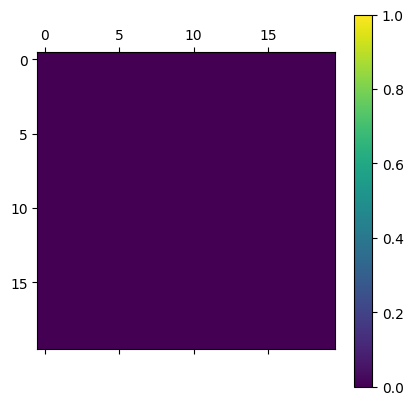

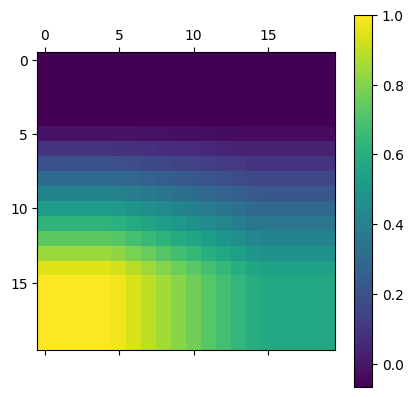

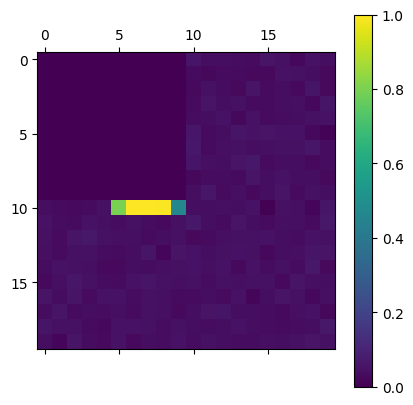

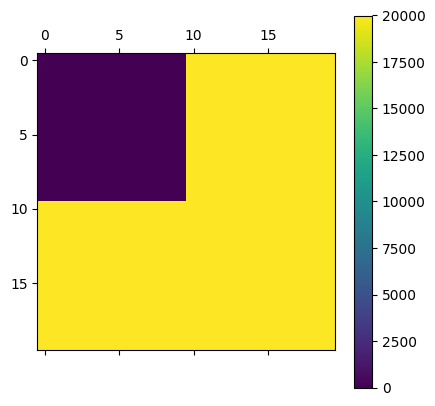

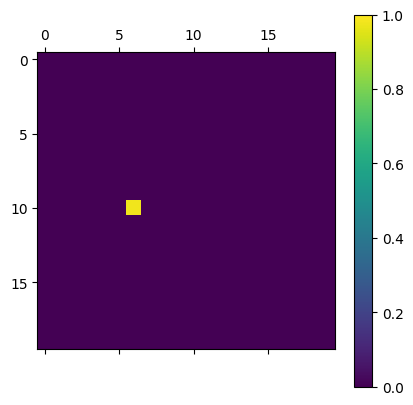

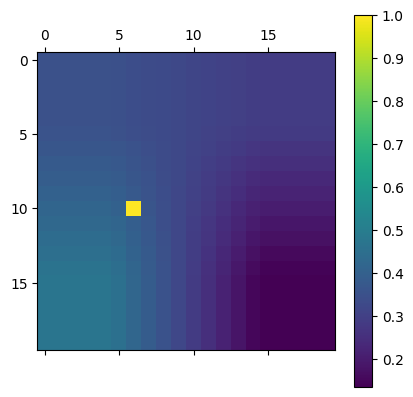

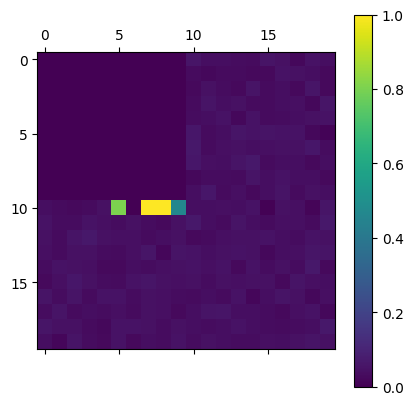

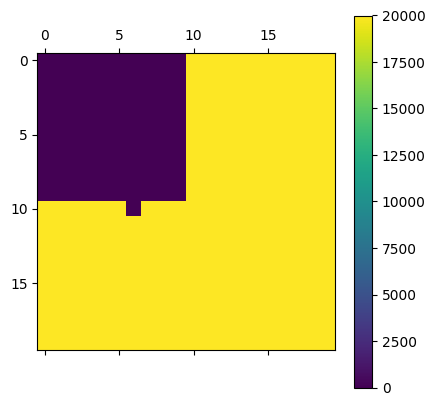

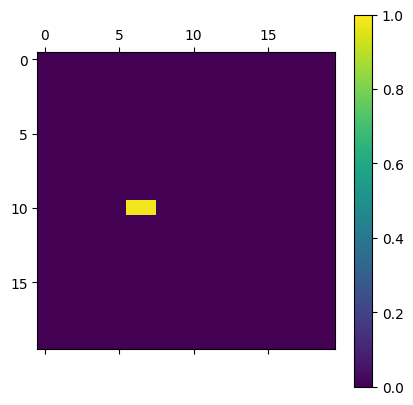

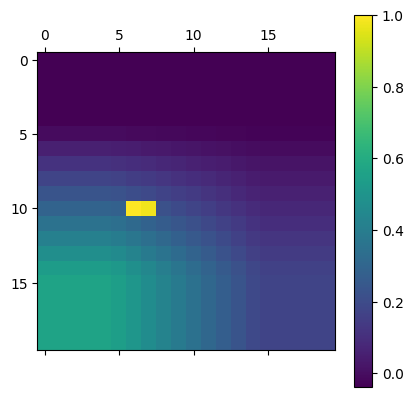

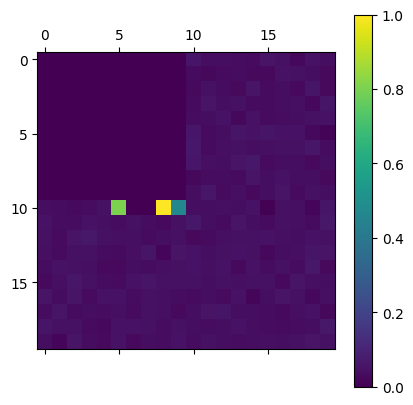

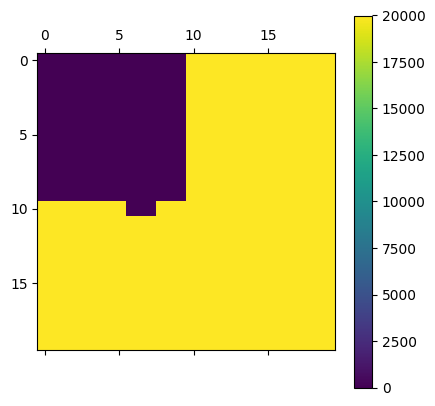

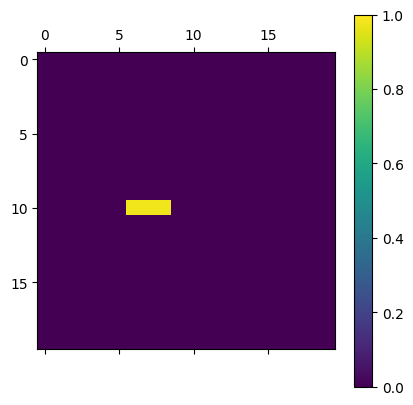

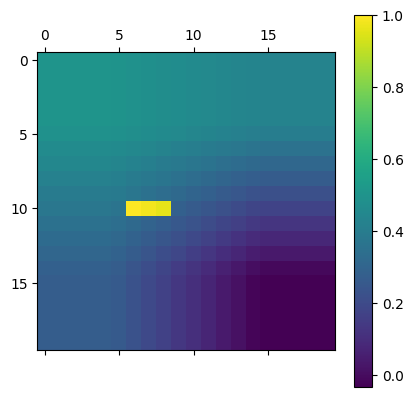

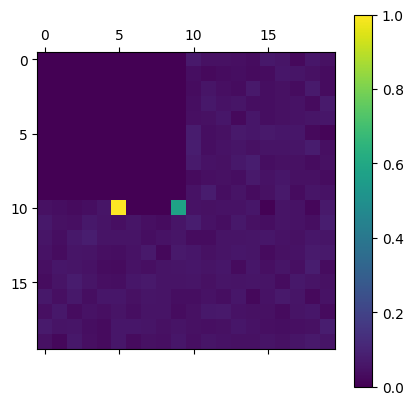

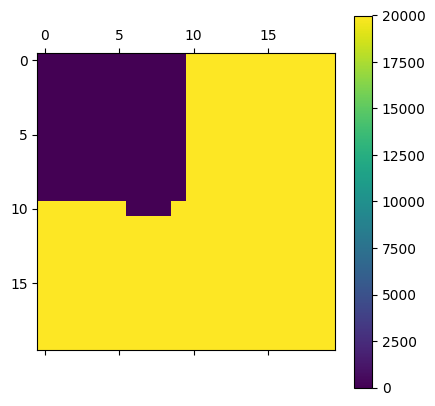

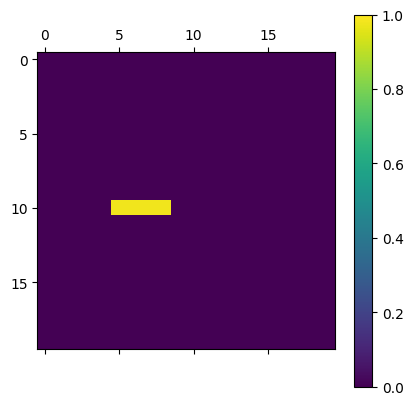

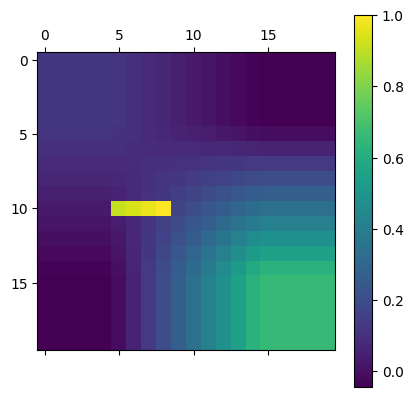

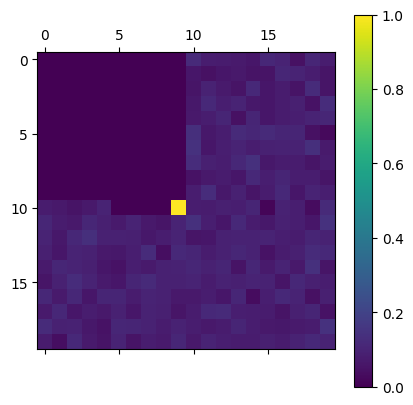

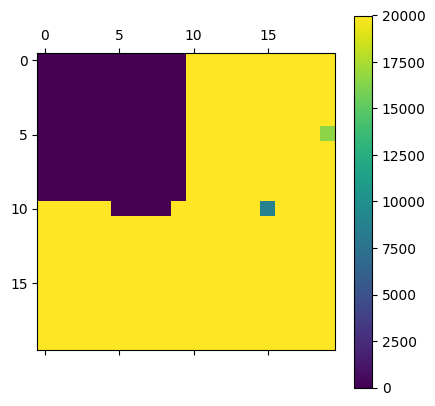

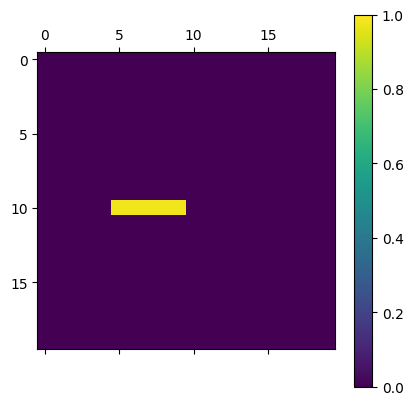

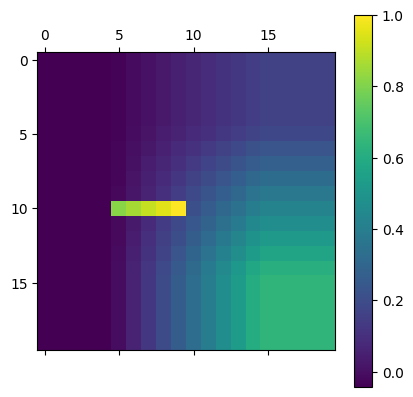

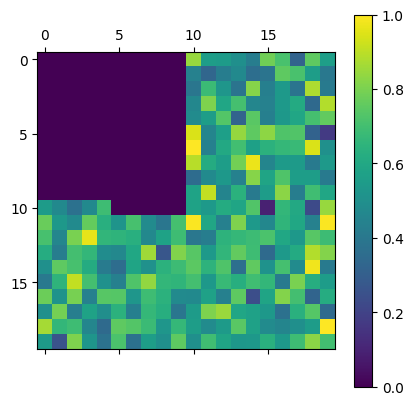

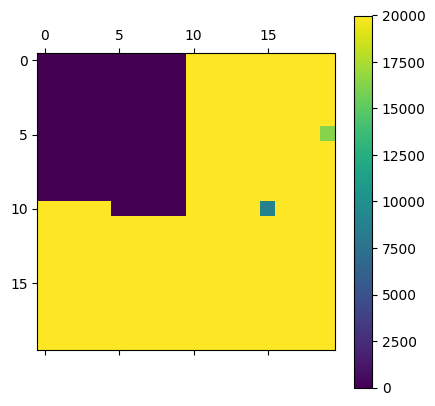

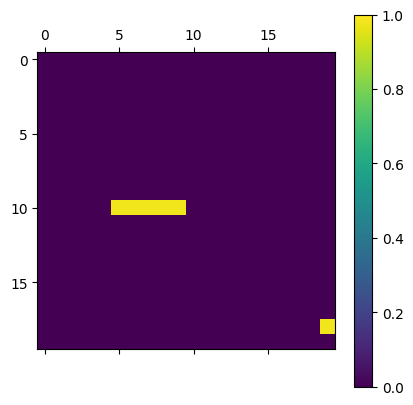

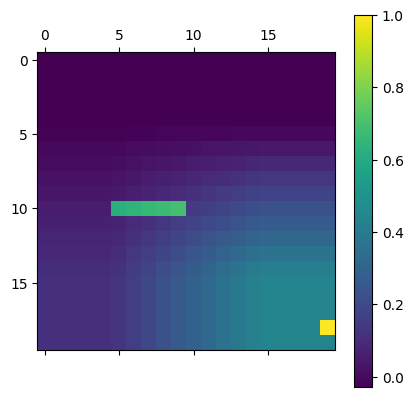

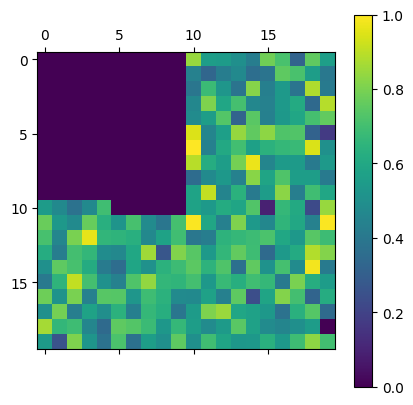

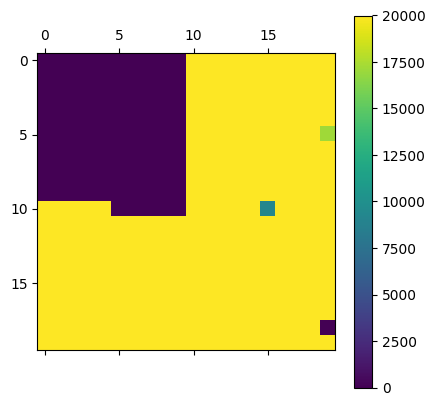

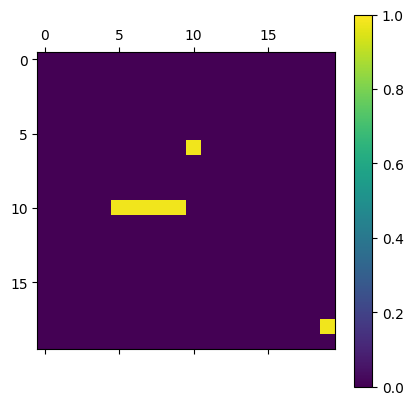

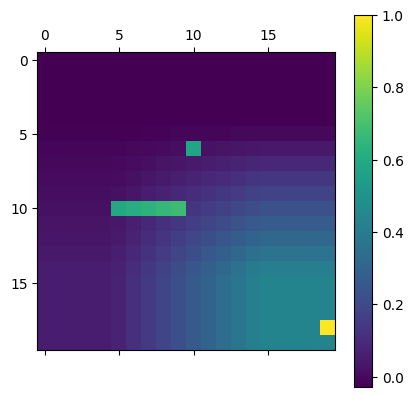

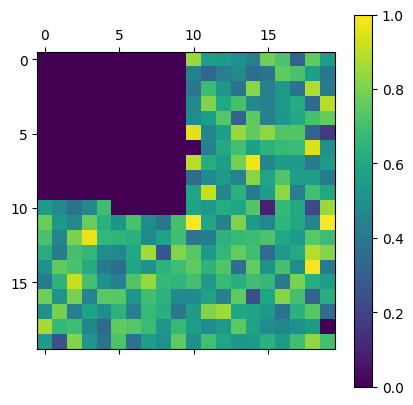

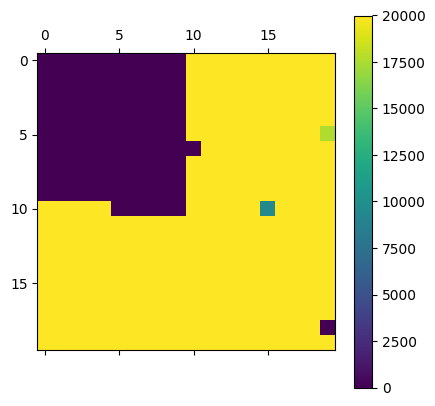

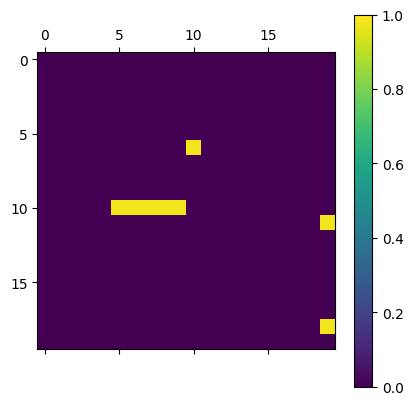

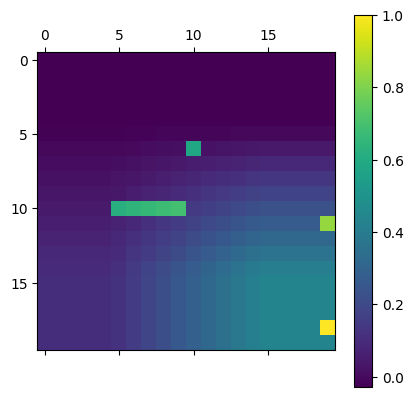

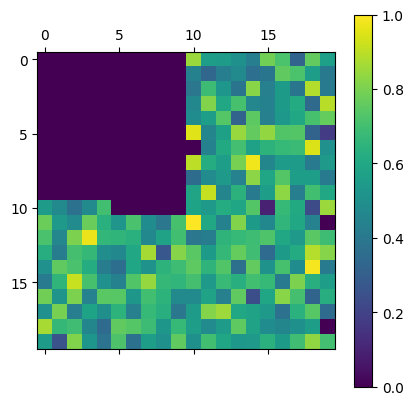

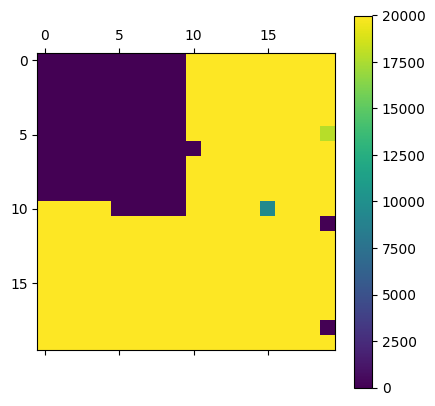

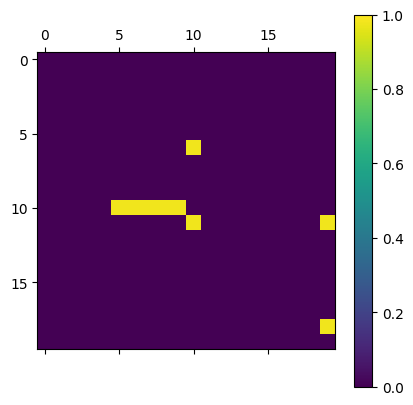

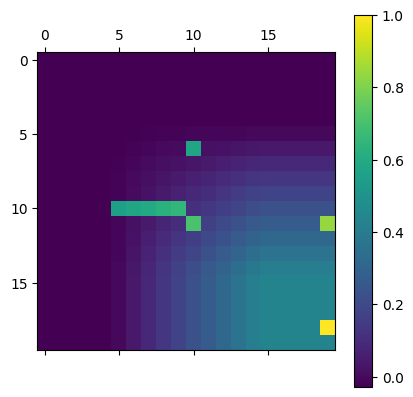

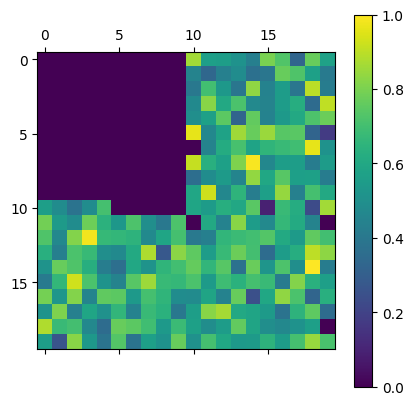

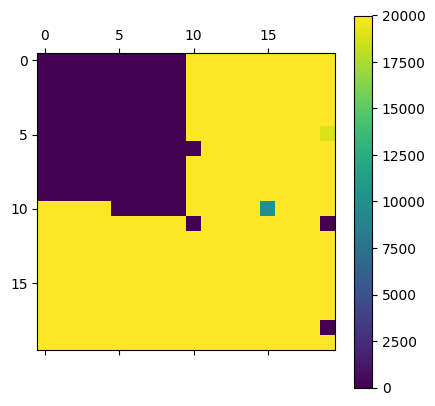

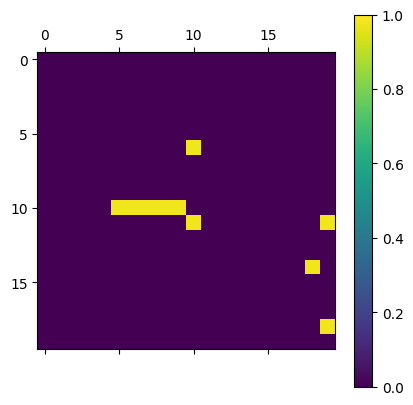

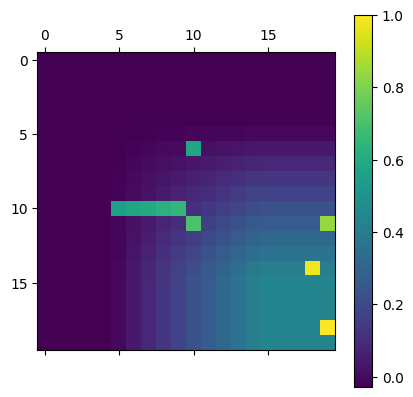

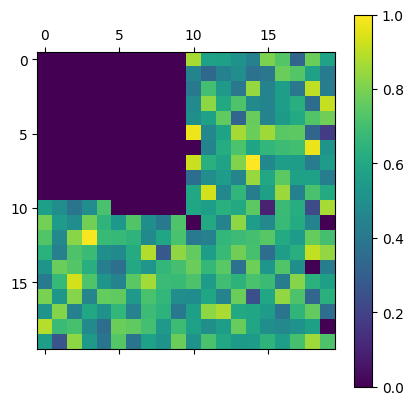

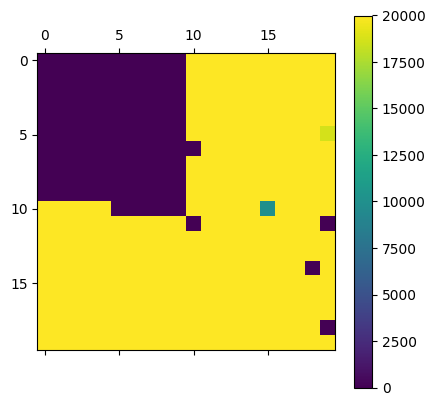

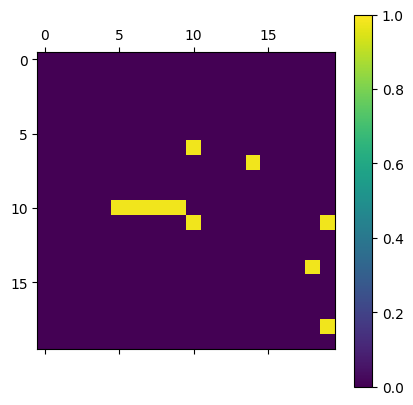

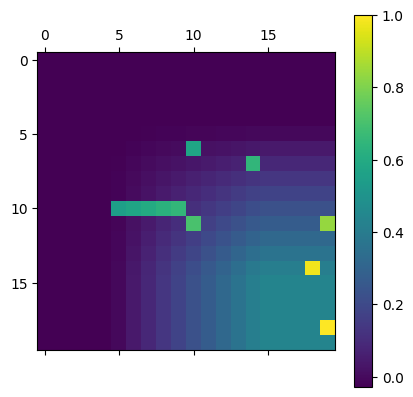

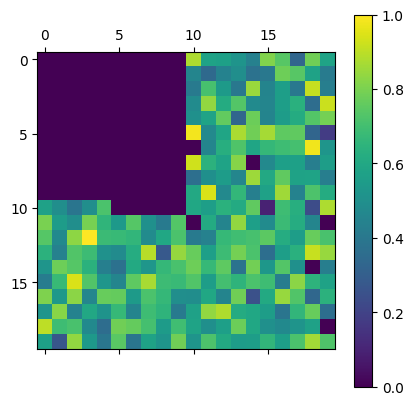

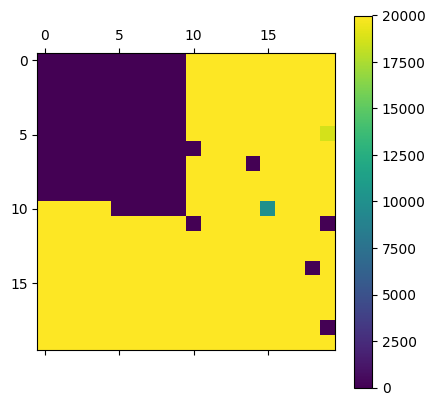

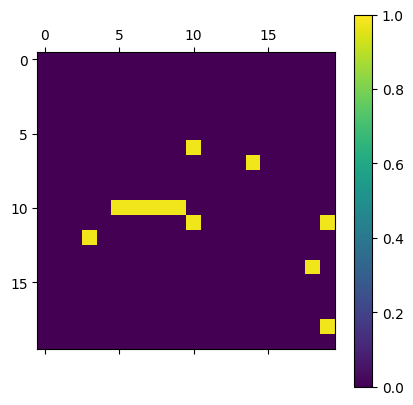

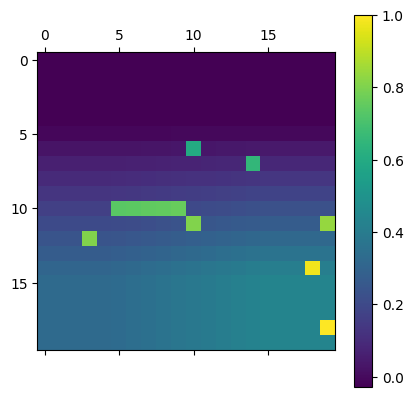

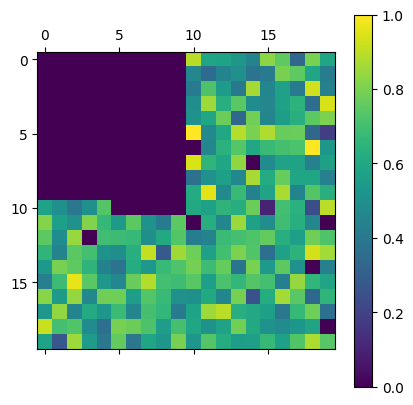

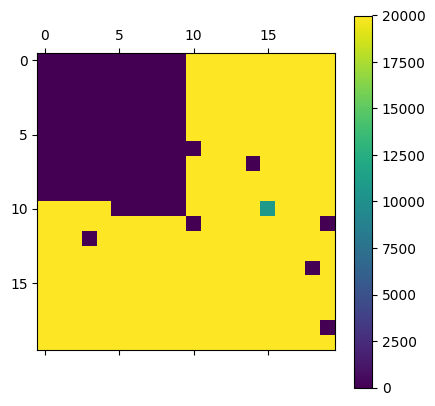

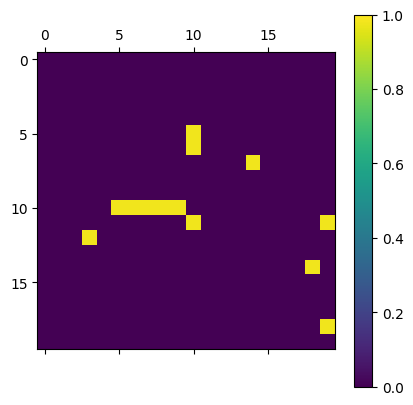

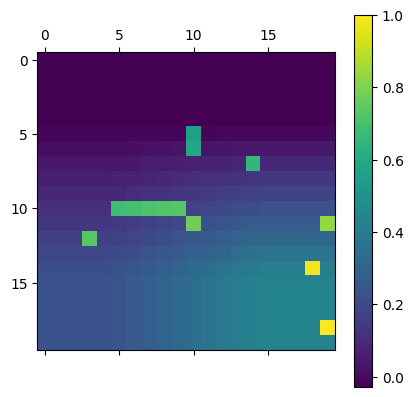

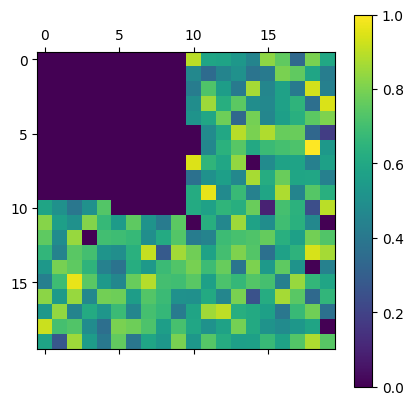

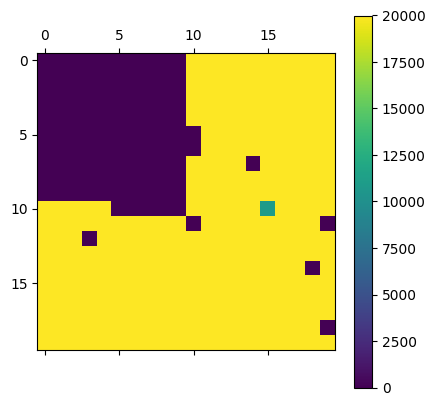

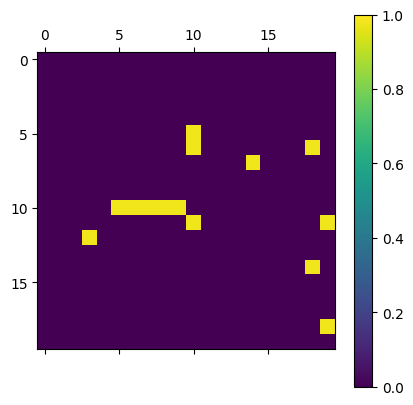

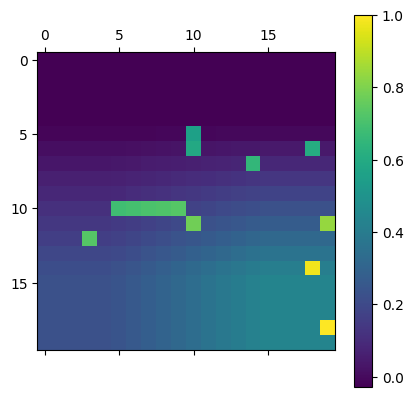

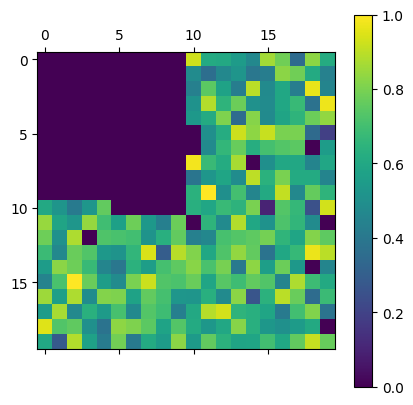

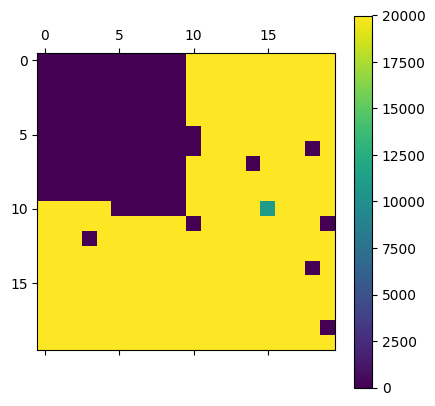

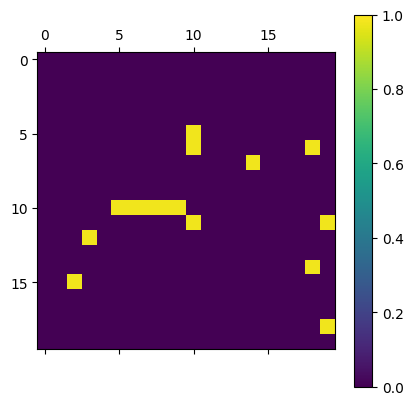

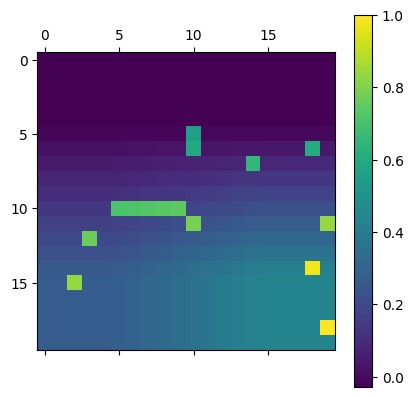

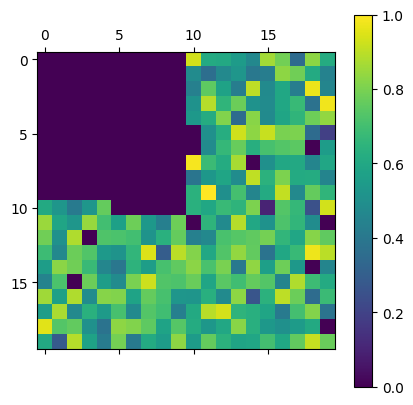

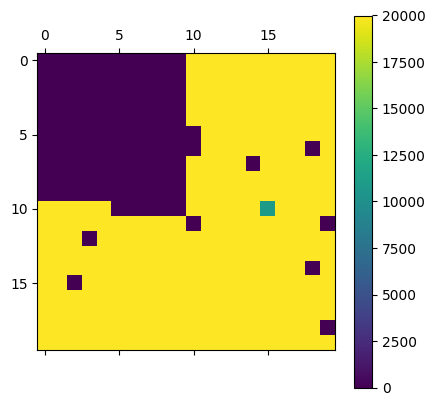

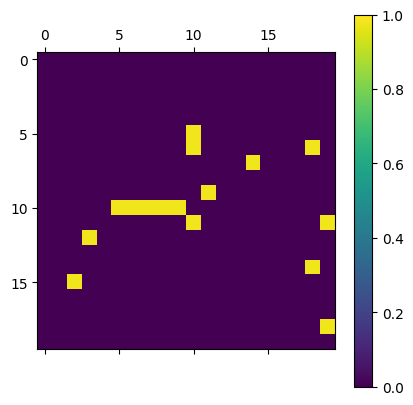

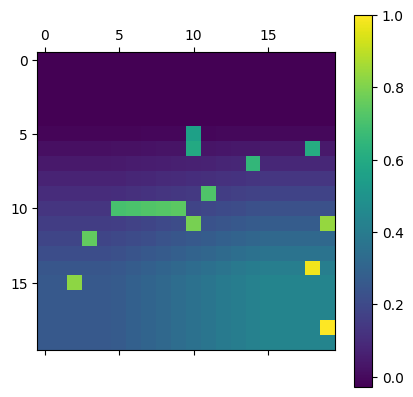

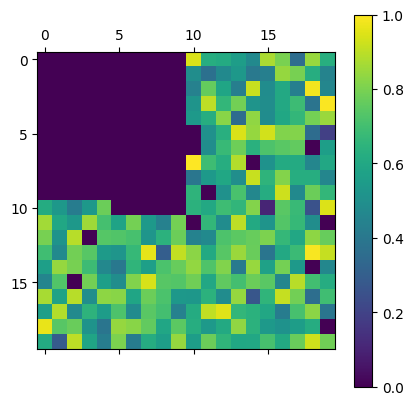

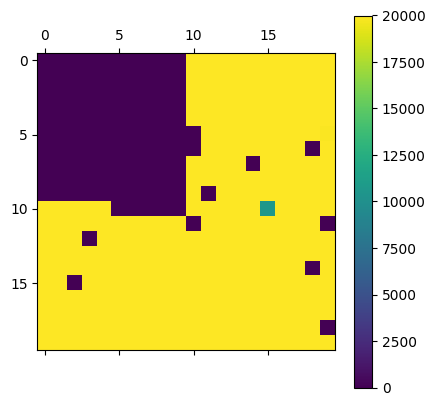

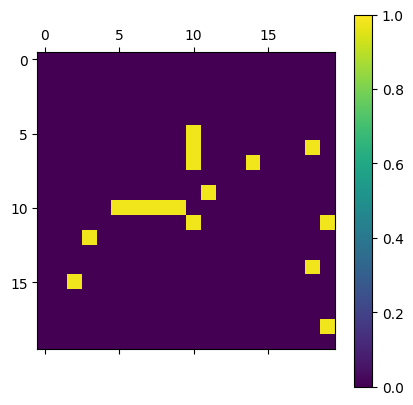

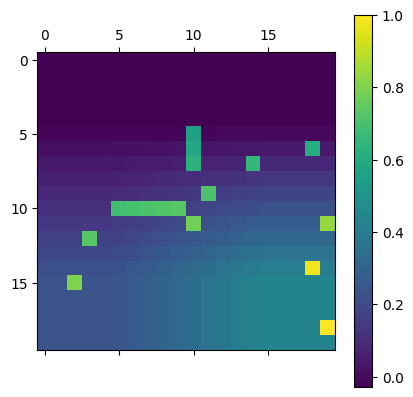

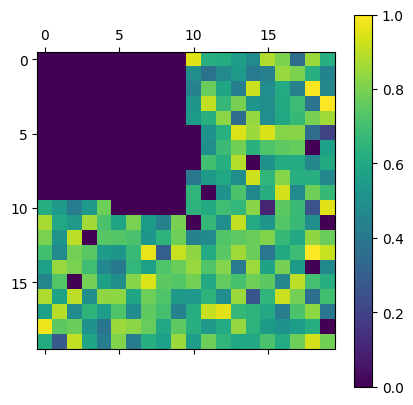

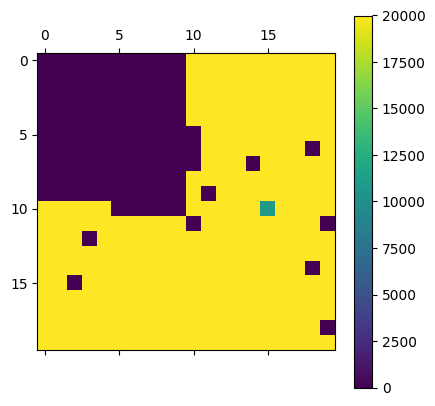

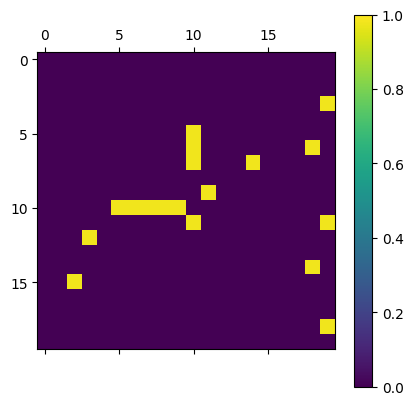

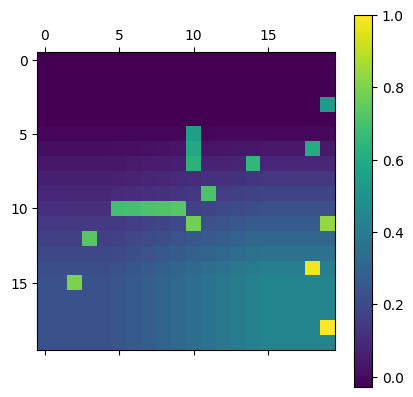

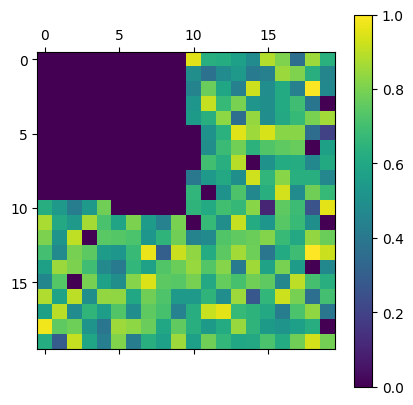

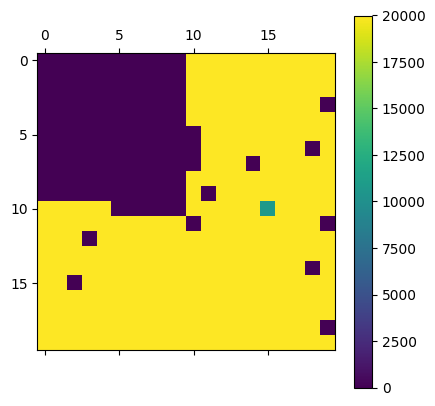

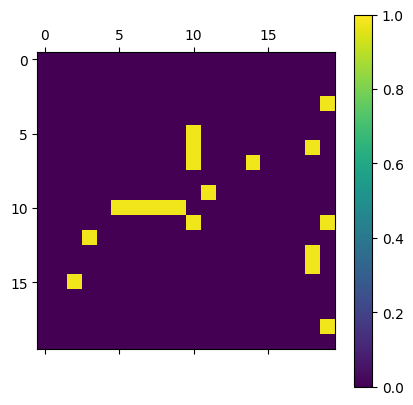

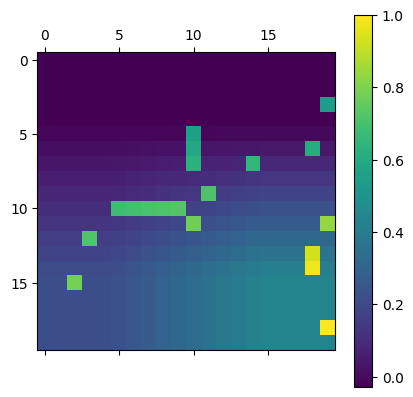

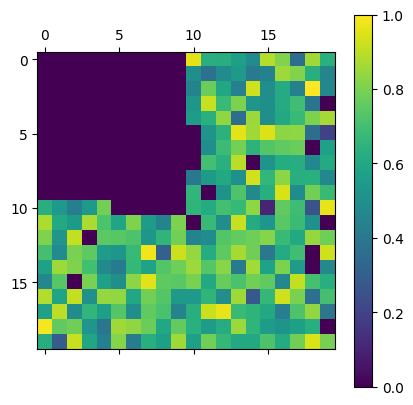

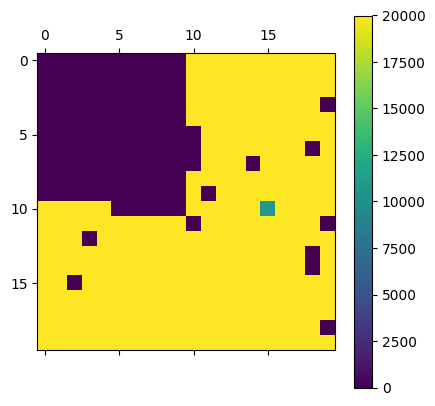

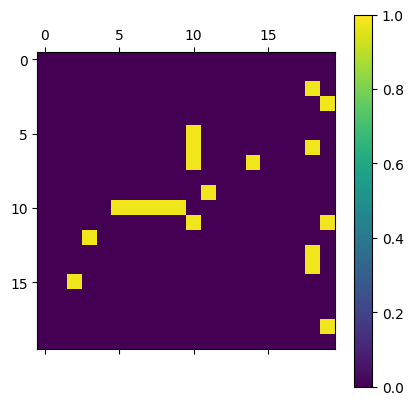

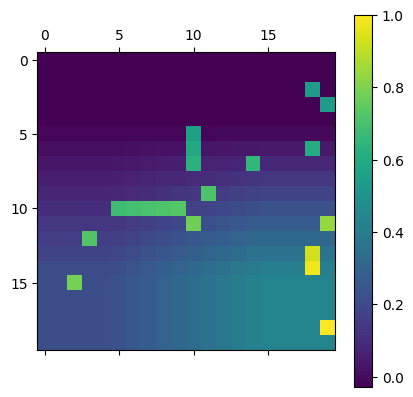

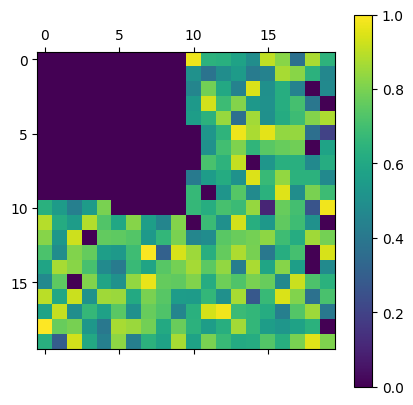

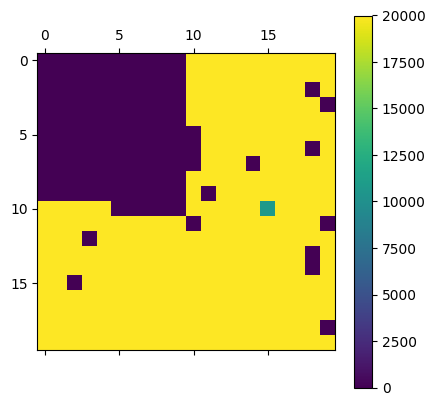

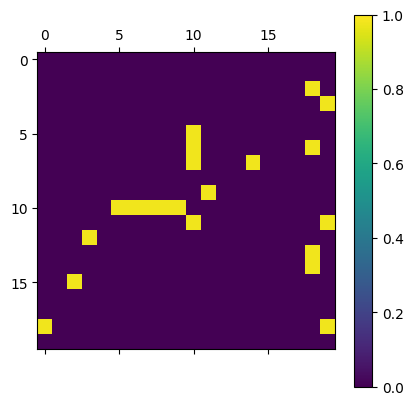

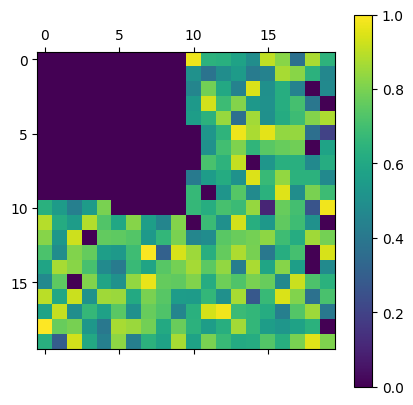

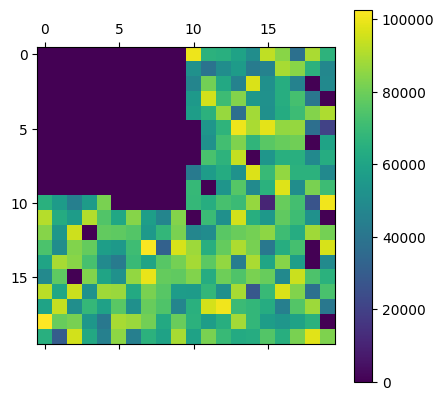

In [7]:
if grid_size == 20 and instance == "homo_1":
    v_max = 2e4
elif grid_size == 20 and instance == "homo_2":
    v_max = 3e6
elif grid_size == 10 and instance == "homo_2":
    v_max = 2e6
else:
    v_max = 5e6
env.reset()
state = env._space[1].unsqueeze(0)
selected_actions = []
path_1 = f"dqn/"
path_2 = f"{instance}/{network}/sub{grid_size}x{grid_size}/"
path_3 = ["grads", "qs", "qs-unormalized", "q_rank"]
for i in path_3:
    try:
        os.makedirs(path_1 + path_2 + i)
    except:
        pass
for k in path_3:
    p = path_1 + path_2 + k + '/'
    for file in os.listdir(p):
        os.remove(p + file)
for i in range(env.get_episode_len()):
    grad = []
    activation = []
    q = net(state)
    if i == 0:
        q_init = q
    selected_action = net.sample(q, state)
    loss = q[0,int(selected_action.item())]
    net.zero_grad()
    loss.backward()
    selected_actions.append(int(selected_action.item()))
    grads = grad[0].data.numpy().squeeze()
    print(grads.shape)
    fmap = activation[0].data.numpy().squeeze()
    tmp = grads.reshape(grads.shape[0], -1)
    weights = np.mean(tmp, axis = 1)
    cam = np.zeros(grads.shape[1:])
    for j,w in enumerate(weights):
        cam += w*fmap[j,:]
    cam = cam*(cam>0)
    heatmap = cam/np.max(cam)
    heatmap = cv2.resize(heatmap, (state.shape[1], state.shape[2]))
    heatmap = np.array(heatmap, dtype='f')
    img = state.numpy().squeeze() - 0.01980198
    superimposed_img = heatmap*0.8 -0.05 + img
    plt.matshow(img, vmin=0, vmax=1)
    plt.colorbar()
    plt.savefig(f"{path_1+path_2}/grads/action-{selected_actions[i]}_sub{grid_size}x{grid_size}_{instance}.png")
    plt.matshow(superimposed_img/superimposed_img.max())
    plt.colorbar()
    plt.savefig(f"{path_1+path_2}/grads/gradcam-{selected_actions[i]}_sub{grid_size}x{grid_size}_{instance}.png")
    _, _, _ = env.step(selected_action)
    state = env._space[1].unsqueeze(0)  
    q = torch.where(torch.isclose(q,torch.Tensor([torch.finfo(q.dtype).min])), 0, q)
    q_min = q.min()
    q_norm = (q-q_min)/(q.max() - q_min)
    plt.matshow((q_norm).reshape(grid_size, grid_size).detach().numpy())
    plt.colorbar()
    plt.savefig(f"{path_1+path_2}/qs/Q:-{selected_actions[i]}_{grid_size}x{grid_size}_{instance}.png")
    plt.matshow(q.reshape(grid_size, grid_size).detach().numpy(), vmin=0, vmax=v_max)
    plt.colorbar()
    plt.savefig(f"{path_1+path_2}/qs-unormalized/Q_unormalized:-{selected_actions[i]}_{grid_size}x{grid_size}_{instance}.png")
    
    
img = state.numpy().squeeze() - 0.01980198
plt.matshow(img, vmin=0, vmax=1)
plt.colorbar()
plt.savefig(f"{path_1+path_2}/grads/action_final_sub{grid_size}x{grid_size}_{instance}.png")
q = torch.where(torch.isclose(q,torch.Tensor([torch.finfo(q.dtype).min])), 0, q)
q_min = q.min()
q_norm = (q-q_min)/(q.max() - q_min)
plt.matshow((q_norm).reshape(grid_size, grid_size).detach().numpy())
plt.colorbar()
plt.savefig(f"{path_1+path_2}/qs/Q:final_sub{grid_size}x{grid_size}_{instance}.png")
plt.matshow(q.reshape(grid_size, grid_size).detach().numpy())
plt.colorbar()
plt.savefig(f"{path_1+path_2}/qs-unormalized/Q_unormalized:final_sub{grid_size}x{grid_size}_{instance}.png")


In [8]:
rank = list(q_init.squeeze().detach().numpy().argsort())
rank.reverse()

In [9]:
ordered_solution = np.zeros((grid_size,grid_size))
order = env.get_episode_len()
limit = env.get_episode_len()
for i in rank[:limit]:
    x, y = np.unravel_index([i], (grid_size,grid_size))
    ordered_solution[x, y] = order
    order -= 1

In [10]:
path_1 + path_2

'dqn/homo_1/small-mobile/sub20x20/'

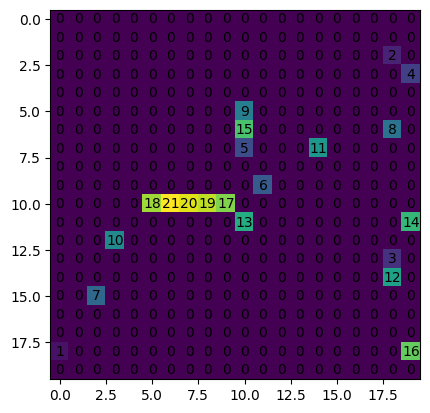

In [11]:
fig, ax = plt.subplots()
ax.imshow(ordered_solution)
for (i, j), z in np.ndenumerate(ordered_solution.astype(int)):
    ax.text(j, i, '{}'.format(z), ha='center', va='center', size=10)
plt.savefig(f"{path_1+path_2}q_rank/initial_q_sub{grid_size}x{grid_size}_{instance}.png")